# Course Project
## Introduction
For this project, use data of hotel booking information to predict if a particular booking will be canceled or not. I'll use logistic regression, decision tree, and random forest and compare them to choose the best model.
## Dataset
The dataset is on [kaggle](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand).
### Download
First, download the dataset from [opendataset](https://github.com/JovianML/opendatasets).

In [110]:
import pandas as pd
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

In [5]:
dataset_url = 'https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand'

In [6]:
od.download(dataset_url)

Skipping, found downloaded files in "./hotel-booking-demand" (use force=True to force download)


### Load
Load the .csv file into python as dataframe.

In [7]:
import os

In [8]:
data_dir = './hotel-booking-demand'

In [9]:
os.listdir(data_dir)

['hotel_bookings.csv']

In [10]:
import pandas as pd

In [11]:
raw_df = pd.read_csv(data_dir + '/hotel_bookings.csv')

### Basic Info
Analysis some basic information of the dataset. From the output below, see that data have 119390 rows and 32 columns. Although not all rows/columns will be used as training data, it is still more than required (50,000 rows and 5 columns).
It is also clear that is_canceled is the target column for this project.

In [13]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Exploratory Data Analysis and Visualization
First, do some exploratory data analysis and visualization

In [14]:
!pip install plotly matplotlib seaborn --quiet

In [15]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

First, note that arrival date (year, month, week, day of month) maybe have low correlation with the target feature. Following 4 plots shows that the distribution of is date is similar between canceled or not canceled booking, hence we can exclude them as featrues in the training set. However, as they indicate date time, they will be used in train/validation/test data split.

In [ ]:
sns.violinplot(data=raw_df, x='is_canceled', y='arrival_date_year').set(title='year v.s. canceled')

In [ ]:
px.histogram(raw_df, x='arrival_date_month', color='is_canceled', title='month v.s. canceled')

In [ ]:
sns.violinplot(data=raw_df, x='is_canceled', y='arrival_date_week_number').set(title='week v.s. canceled')

In [ ]:
sns.violinplot(data=raw_df, x='is_canceled', y='arrival_date_day_of_month').set(title='day of month v.s. canceled')

Following 2 graphs shows low correlation between stay nights v.s. canceled or not. It is very likely they will not pass chi-square test for feature filtering. However, I decided not use test before the training, so keep them for now.

In [ ]:
sns.violinplot(data=raw_df.sample(5000), y='stays_in_weekend_nights', x='is_canceled')

In [ ]:
sns.violinplot(data=raw_df.sample(5000), y='stays_in_week_nights', x='is_canceled')

Following 2 graphs show that dependent column is correlated with repeat guest and previous cancellation information.

In [ ]:
px.histogram(raw_df, x='is_repeated_guest', color='is_canceled', title='repeat guest v.s. cancel')

In [ ]:
px.scatter(raw_df, x='previous_cancellations', y='previous_bookings_not_canceled', color='is_canceled')

Although country may correlated to target column, many countries have little sample and encod all countries will add many columns in training set, which will increase the running time. Hence, leave it out for now. And agent and company seems to have similar distribution on target columns.

In [ ]:
px.histogram(raw_df, x='country', color='is_canceled')

In [ ]:
px.histogram(raw_df, x='agent', color='is_canceled')

In [ ]:
px.histogram(raw_df, x='company', color='is_canceled')

## Train/Test Split

In [11]:
!pip install scikit-learn --upgrade --quiet

As this data contains datetime columns, and we wish to make model predict future. Hence, it is reasonable to use date_year/date_week_number to split the train/validation/test dataset. However, if we use this method to split the train/validation/test dataset, cross validation will be impossible.

In [23]:
train_df = raw_df[raw_df.arrival_date_year < 2017]

val_test_df = raw_df[raw_df.arrival_date_year == 2017]
val_df = val_test_df[raw_df.arrival_date_week_number <= 25]
test_df = val_test_df[raw_df.arrival_date_week_number > 25]

/var/folders/1x/grh0yg_x7wz6krwc2mtjz9180000gn/T/ipykernel_70686/175770019.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/1x/grh0yg_x7wz6krwc2mtjz9180000gn/T/ipykernel_70686/175770019.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [26]:
print(f'train_df.shape: {train_df.shape}')
print(f'val_df.shape: {val_df.shape}')
print(f'test_df.shape: {test_df.shape}')

train_df.shape: (78703, 32)
val_df.shape: (29301, 32)
test_df.shape: (11386, 32)


In [27]:
import jovian

In [28]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "lubingguang98sh/machinelearningproject-766b4" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/lubingguang98sh/machinelearningproject-766b4


'https://jovian.ai/lubingguang98sh/machinelearningproject-766b4'

## Preprocess
### Identify Input and Target

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78703 entries, 0 to 104219
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           78703 non-null  object 
 1   is_canceled                     78703 non-null  int64  
 2   lead_time                       78703 non-null  int64  
 3   arrival_date_year               78703 non-null  int64  
 4   arrival_date_month              78703 non-null  object 
 5   arrival_date_week_number        78703 non-null  int64  
 6   arrival_date_day_of_month       78703 non-null  int64  
 7   stays_in_weekend_nights         78703 non-null  int64  
 8   stays_in_week_nights            78703 non-null  int64  
 9   adults                          78703 non-null  int64  
 10  children                        78699 non-null  float64
 11  babies                          78703 non-null  int64  
 12  meal                           

As mentioned before, we have is_canceled as target column and have dropped few column from training dataset.

In [30]:
input_cols = ['hotel', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
              'babies', 'meal', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
              'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes',
              'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces',
              'total_of_special_requests']
target_col = 'is_canceled'

In [31]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [32]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [33]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

### Identifying Numeric and Categorical Columns
This can be done by numpy. However, note that is_repeated_guest is a categorical column but have only 0 and 1 value. It is same if we use encoder on 'object' value, hence consider it as numerical column for convenience.

In [34]:
import numpy as np

In [35]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [36]:
numeric_cols

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [37]:
categorical_cols

['hotel',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type']

### imupting Missing Numeric Feature

In [38]:
from sklearn.impute import SimpleImputer

In [39]:
imputer = SimpleImputer(strategy= 'mean').fit(raw_df[numeric_cols])

In [40]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

### Scaling Numeric Feature

In [41]:
from sklearn.preprocessing import MinMaxScaler

In [42]:
scaler = MinMaxScaler().fit(raw_df[numeric_cols])

In [43]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encoding Categorical Feature

In [44]:
from sklearn.preprocessing import OneHotEncoder

In [45]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])

/Users/lubingguang/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [46]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [47]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

### Set Dataframe for train/validation/test

In [48]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

## Train Logistic Regression
### Basic

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
logi_model = LogisticRegression(solver='liblinear')

In [51]:
logi_model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [53]:
accuracy_score(train_targets, logi_model.predict(X_train))

0.8256356174478736

In [54]:
accuracy_score(val_targets, logi_model.predict(X_val))

0.7871403706358144

### Hyperparameter Tuning
For logistic regression, there seems not so much hyperparameters to tuning. Use l2 is valid and no reason to use l1 as penalty. And no reason to ignore the intercept as we are not using PCA (and is not possible as there is categorical features in our dataset).

In [55]:
logi_model_final = logi_model

## Train Decistion Tree (DT)
### Basic

In [56]:
from sklearn.tree import DecisionTreeClassifier

In [57]:
dt_model = DecisionTreeClassifier(random_state=42)

In [58]:
dt_model.fit(X_train, train_targets)

DecisionTreeClassifier(random_state=42)

In [59]:
accuracy_score(train_targets, dt_model.predict(X_train))

0.9898987332122028

In [60]:
accuracy_score(val_targets, dt_model.predict(X_val))

0.729258387085765

It is clear that the DT model have problem of overfit (high variance)
### Hyperparameter Tuning

In [63]:
def test_params(**params):
    model = DecisionTreeClassifier(random_state=42, **params).fit(X_train, train_targets)
    return model.score(X_train, train_targets), model.score(X_val, val_targets)

#### max_depth
Seems max_depth=15 is the best value.

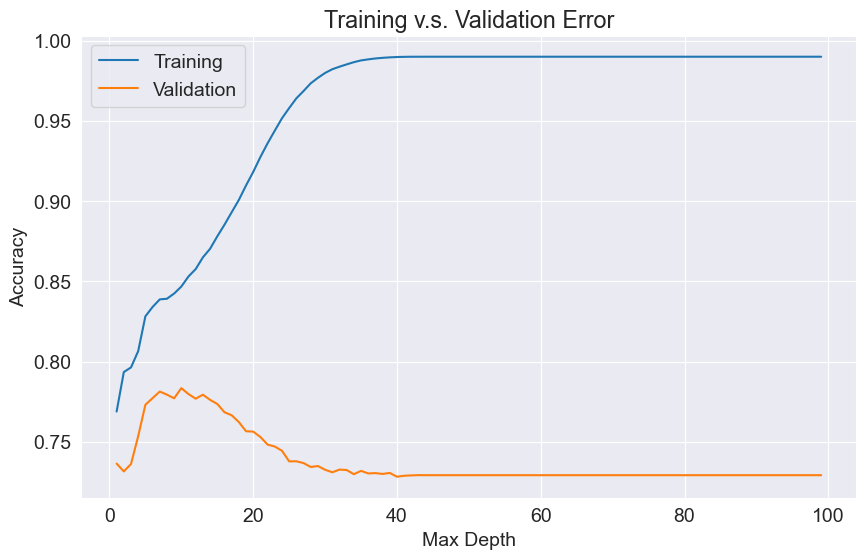

In [86]:
errors_df = pd.DataFrame([test_params(max_depth=n) for n in range(1, 100)])

plt.figure()
plt.plot(list(range(1, 100)), errors_df[0])
plt.plot(list(range(1, 100)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### max_leaf_nodes
See that max_leaf_nodes=10 is good enough.

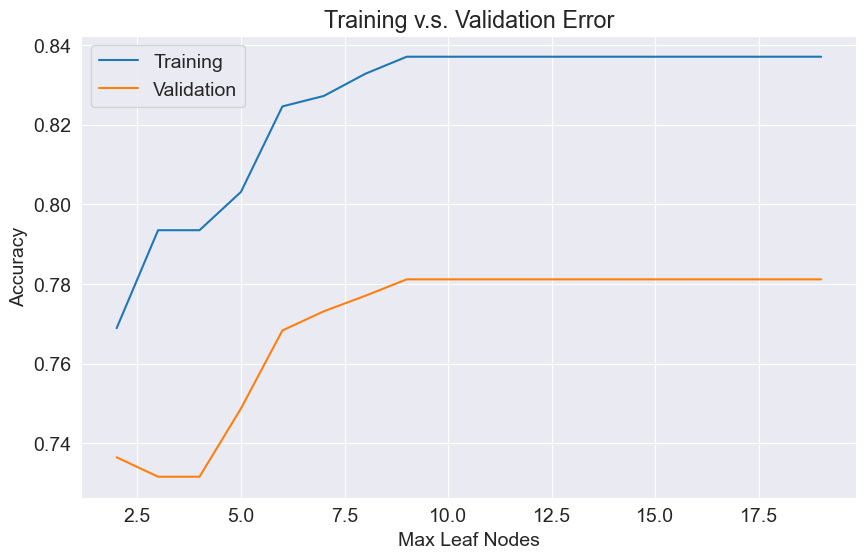

In [87]:
errors_df = pd.DataFrame([test_params(max_depth=15, max_leaf_nodes=n) for n in range(2, 20)])

plt.figure()
plt.plot(list(range(2, 20)), errors_df[0])
plt.plot(list(range(2, 20)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### min_samples_split
Seems have no effect on accuracy on range (2, 10)

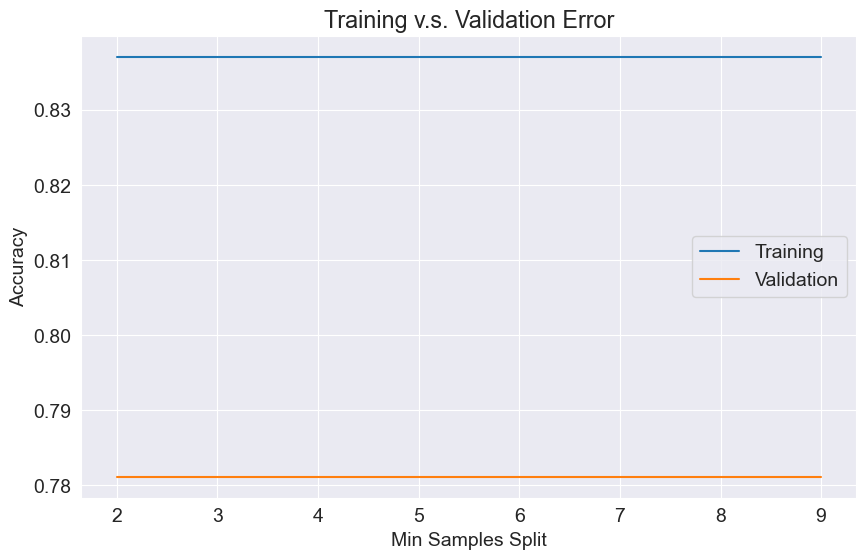

In [93]:
errors_df = pd.DataFrame([test_params(max_depth=15, max_leaf_nodes=10, min_samples_split=n) for n in range(2, 10)])

plt.figure()
plt.plot(list(range(2, 10)), errors_df[0])
plt.plot(list(range(2, 10)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### min_samples_leaf
Similar result.

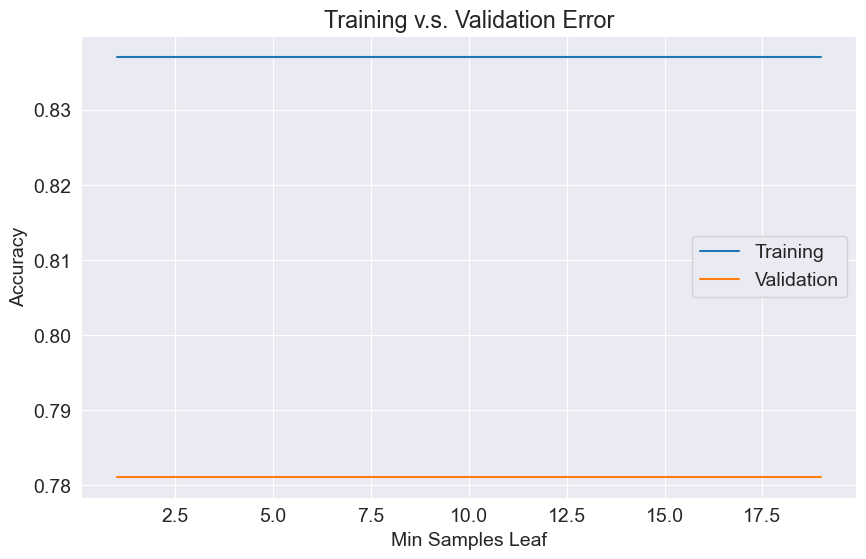

In [94]:
errors_df = pd.DataFrame([test_params(max_depth=15, max_leaf_nodes=10, min_samples_split=2,
                                      min_samples_leaf=n) for n in range(1, 20)])

plt.figure()
plt.plot(list(range(1, 20)), errors_df[0])
plt.plot(list(range(1, 20)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### min_impurity_decrease
For impurity threshold, lower is better. Hence, keep it as 0 as our dataset is not huge.

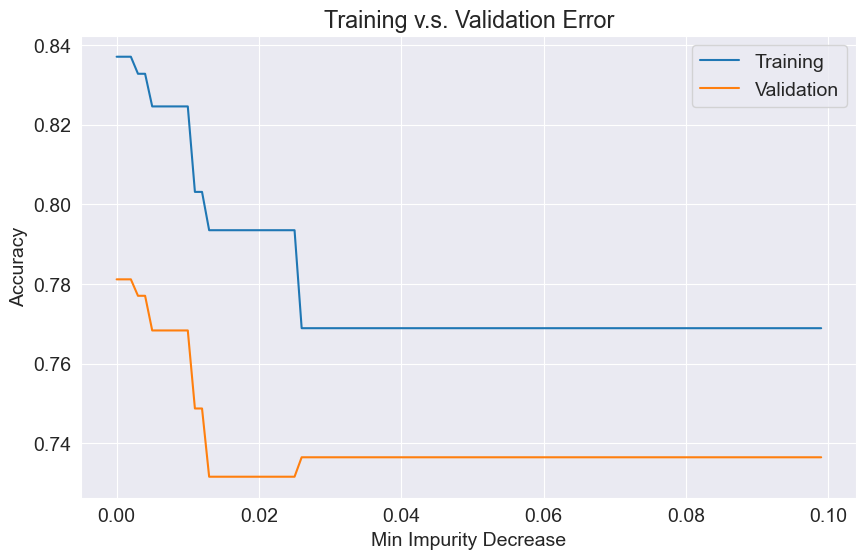

In [96]:
errors_df = pd.DataFrame([test_params(max_depth=15, max_leaf_nodes=10, min_samples_split=2,
                                      min_samples_leaf=1, min_impurity_decrease=n) for n in np.arange(0, 0.1, 0.001)])

plt.figure()
plt.plot(list(np.arange(0, 0.1, 0.001)), errors_df[0])
plt.plot(list(np.arange(0, 0.1, 0.001)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Min Impurity Decrease')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### Repeat
Repeat more times to get 'best' hyperparameters.

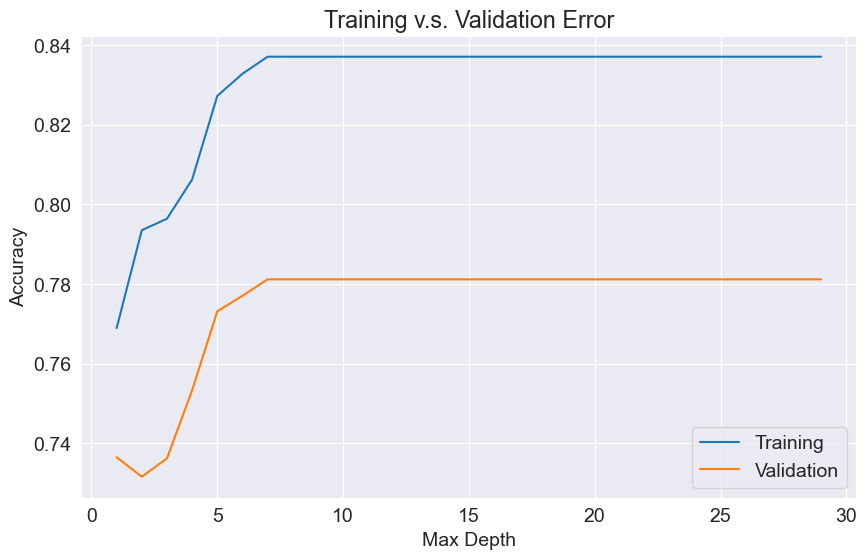

In [101]:
errors_df = pd.DataFrame([test_params(max_depth=n, max_leaf_nodes=10, min_samples_split=2,
                                      min_samples_leaf=1, min_impurity_decrease=0) for n in range(1, 30)])

plt.figure()
plt.plot(list(range(1, 30)), errors_df[0])
plt.plot(list(range(1, 30)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

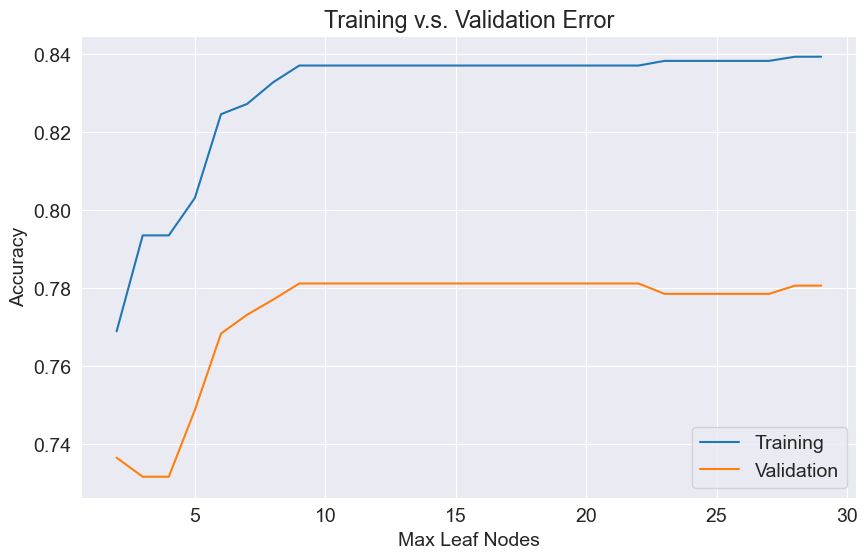

In [103]:
errors_df = pd.DataFrame([test_params(max_depth=10, max_leaf_nodes=n, min_samples_split=2,
                                      min_samples_leaf=1, min_impurity_decrease=0) for n in range(2, 30)])

plt.figure()
plt.plot(list(range(2, 30)), errors_df[0])
plt.plot(list(range(2, 30)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### Hyperparameter Tuning Final Model
As max_leaf_nodes does not chage, no need to repeat as will give exactly same result. Hence, the model for hyperparameter tuning is:

In [105]:
dt_model_hptun = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10, min_samples_split=2,
                                        min_samples_leaf=1, min_impurity_decrease=0).fit(X_train, train_targets)

In [106]:
dt_model_hptun.score(X_train, train_targets)

0.8370583078154581

In [107]:
dt_model_hptun.score(X_val, val_targets)

0.7811678782294119

### Final Model

In [112]:
dt_model_final = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10, min_samples_split=2,
                                        min_samples_leaf=1, min_impurity_decrease=0).fit(X_train, train_targets)

## Random Forest (RF)
### Basic

In [113]:
from sklearn.ensemble import RandomForestClassifier

In [114]:
rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)

In [115]:
rf_model.fit(X_train, train_targets)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [116]:
rf_model.score(X_train, train_targets)

0.9898733212202838

In [117]:
rf_model.score(X_val, val_targets)

0.7738643732295826

In [118]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### Hyperparameter Tuning

In [119]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    return model.score(X_train, train_targets), model.score(X_val, val_targets)

#### n_estimators
n_estimators=18 already gives reasonable high accuracy.

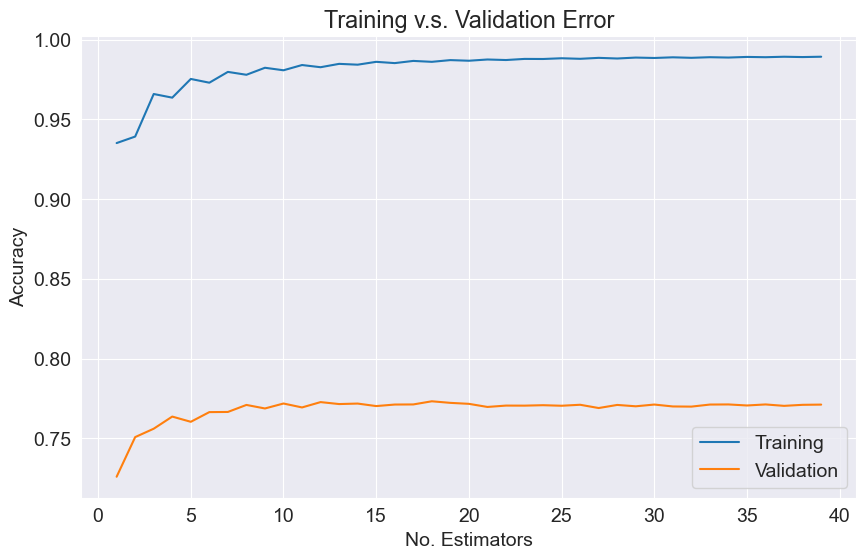

In [126]:
errors_df = pd.DataFrame([test_params(n_estimators=n) for n in range(1, 40)])

plt.figure()
plt.plot(list(range(1, 40)), errors_df[0])
plt.plot(list(range(1, 40)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('No. Estimators')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### max_depth
max_depth=18 gives the highest validation accuracy.

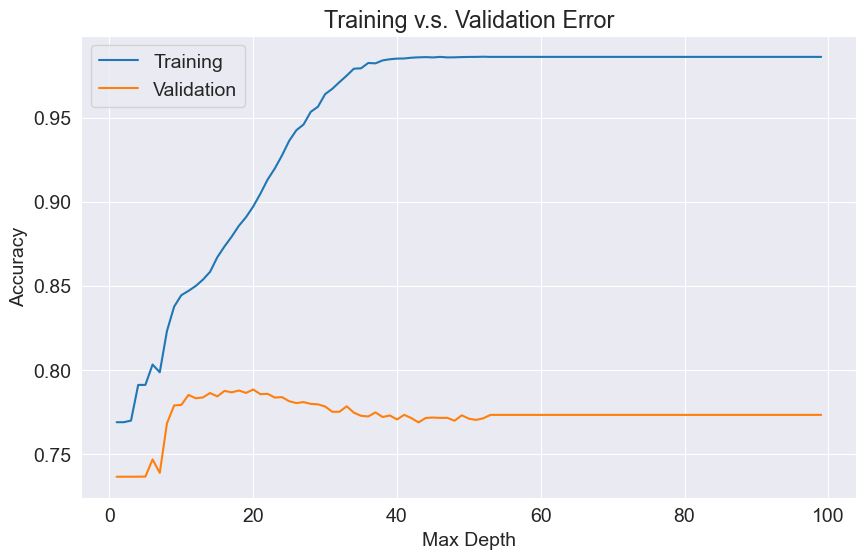

In [128]:
errors_df = pd.DataFrame([test_params(n_estimators=18, max_depth=n) for n in range(1, 100)])

plt.figure()
plt.plot(list(range(1, 100)), errors_df[0])
plt.plot(list(range(1, 100)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### max_leaf_nodes
70 is the reasonable value.

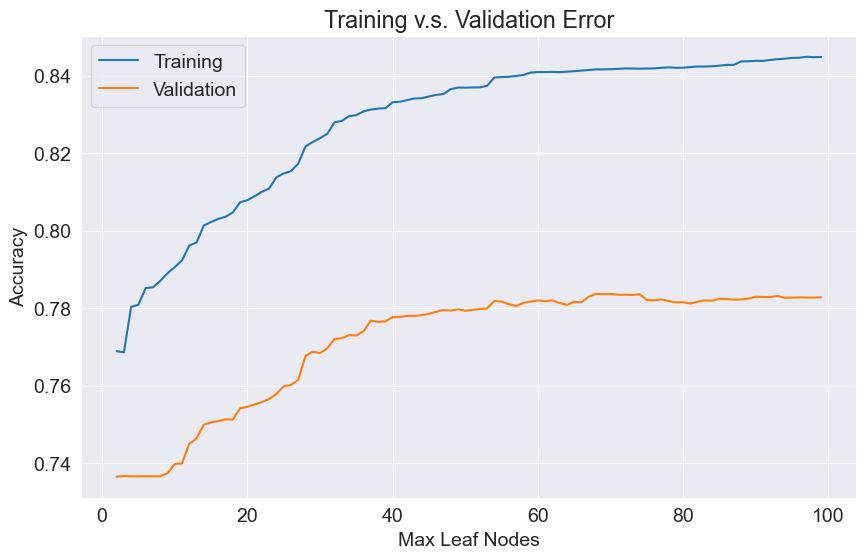

In [135]:
errors_df = pd.DataFrame([test_params(n_estimators=18, max_depth=18, max_leaf_nodes=n) for n in range(2, 100)])

plt.figure()
plt.plot(list(range(2, 100)), errors_df[0])
plt.plot(list(range(2, 100)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### max_features
10 is reasonable good.

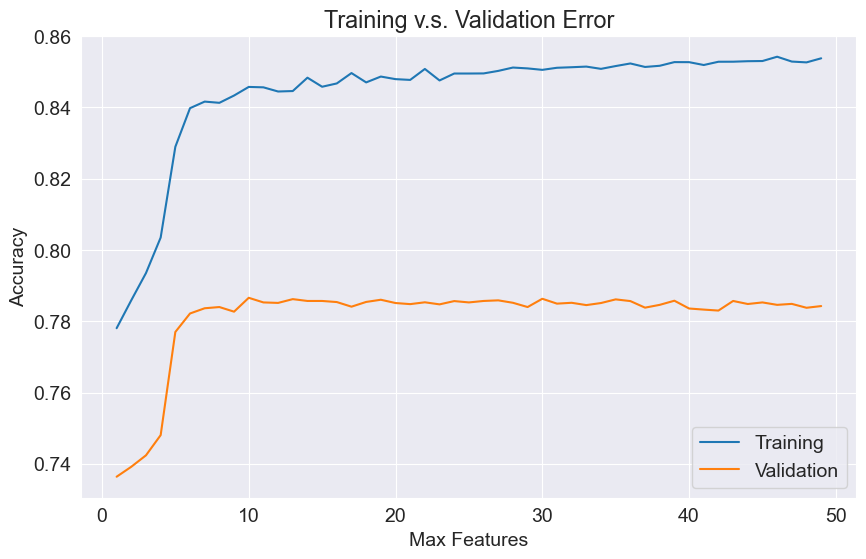

In [137]:
errors_df = pd.DataFrame([test_params(n_estimators=18, max_depth=18, max_leaf_nodes=70, max_features=n) for n in range(1, 50)])

plt.figure()
plt.plot(list(range(1, 50)), errors_df[0])
plt.plot(list(range(1, 50)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### min_samples_split
Choose 16 for this round.

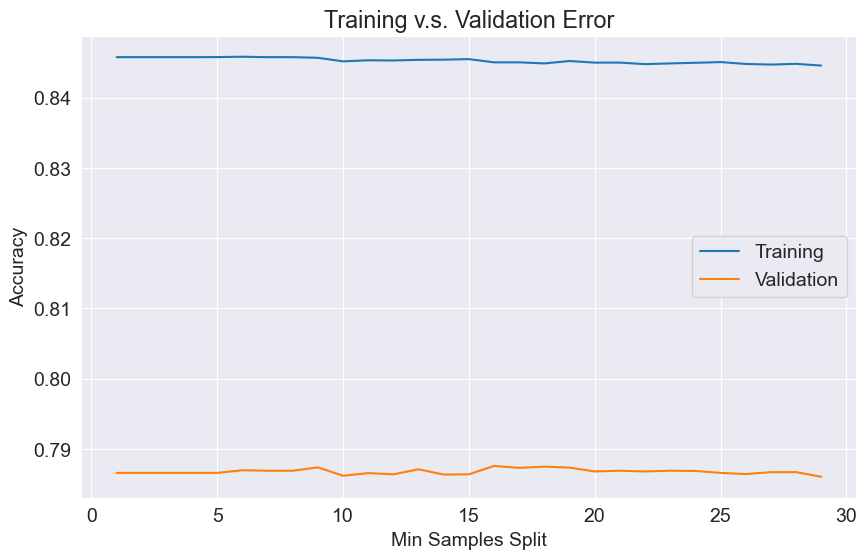

In [140]:
errors_df = pd.DataFrame([test_params(n_estimators=18, max_depth=18, max_leaf_nodes=70, max_features=10,
                                      min_samples_split=n) for n in range(1, 30)])

plt.figure()
plt.plot(list(range(1, 30)), errors_df[0])
plt.plot(list(range(1, 30)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### min_samples_leaf
Choose 1 for this round

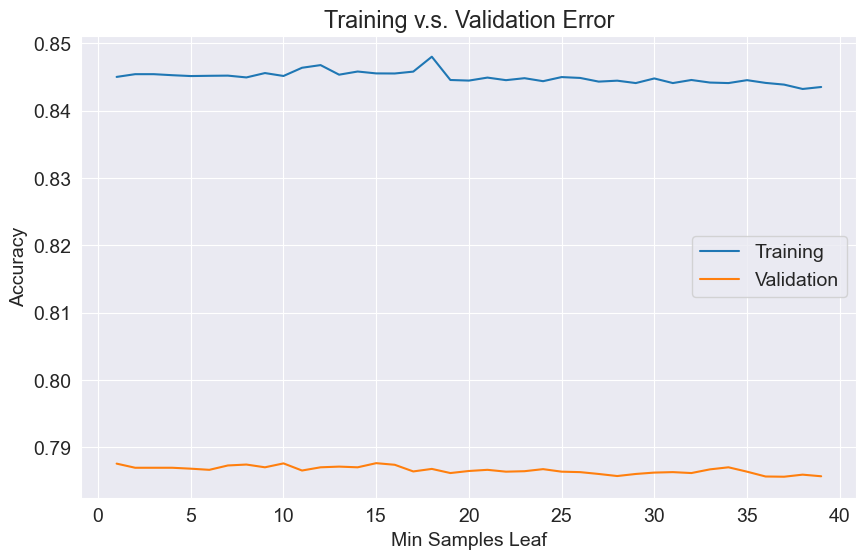

In [143]:
errors_df = pd.DataFrame([test_params(n_estimators=18, max_depth=18, max_leaf_nodes=70, max_features=10,
                                      min_samples_split=16, min_samples_leaf=n) for n in range(1, 40)])

plt.figure()
plt.plot(list(range(1, 40)), errors_df[0])
plt.plot(list(range(1, 40)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### min_impurity_decrease
Hence accuracy drop a lot, choose to be 0.

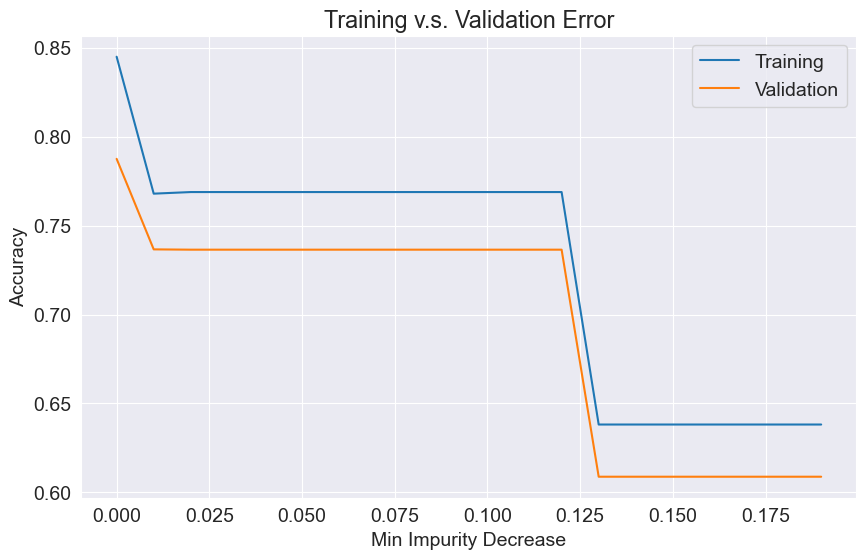

In [144]:
errors_df = pd.DataFrame([test_params(n_estimators=18, max_depth=18, max_leaf_nodes=70, max_features=10,
                                      min_samples_split=16, min_samples_leaf=1,
                                      min_impurity_decrease=n) for n in np.arange(0, 0.2, 0.01)])

plt.figure()
plt.plot(list(np.arange(0, 0.2, 0.01)), errors_df[0])
plt.plot(list(np.arange(0, 0.2, 0.01)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Min Impurity Decrease')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### max_samples
Choose 0.5 this round.

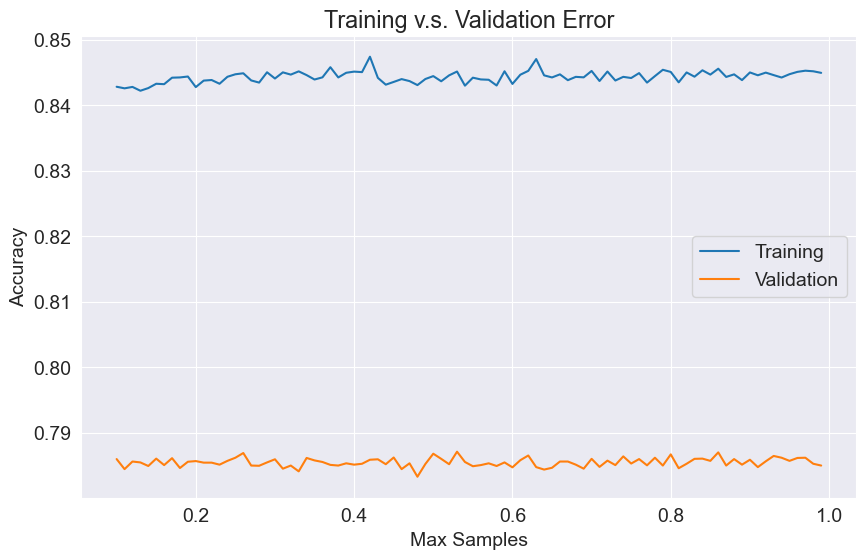

In [148]:
errors_df = pd.DataFrame([test_params(n_estimators=18, max_depth=18, max_leaf_nodes=70, max_features=10,
                                      min_samples_split=16, min_samples_leaf=1,
                                      min_impurity_decrease=0, max_samples=n) for n in np.arange(0.1, 1, 0.01)])

plt.figure()
plt.plot(list(np.arange(0.1, 1, 0.01)), errors_df[0])
plt.plot(list(np.arange(0.1, 1, 0.01)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Samples')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### Repeat
Repeat the process above to see if can be further improved.

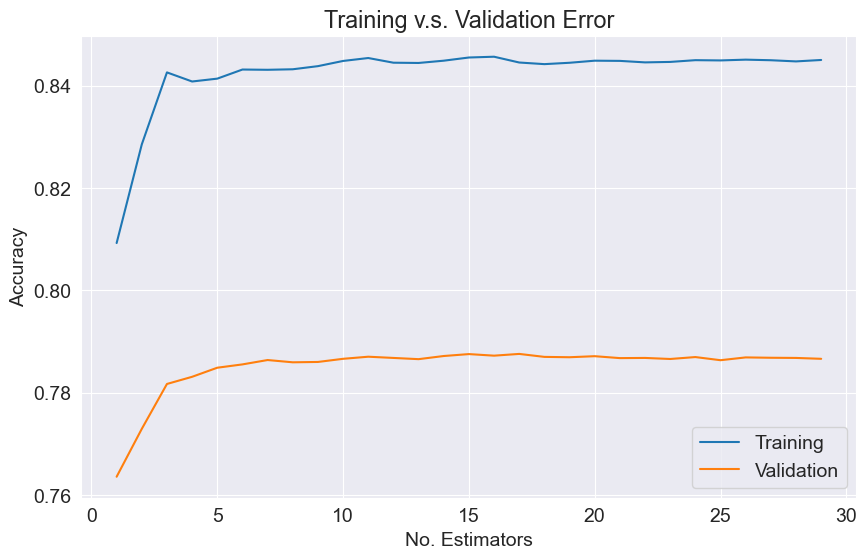

In [150]:
errors_df = pd.DataFrame([test_params(n_estimators=n, max_depth=18, max_leaf_nodes=70, max_features=10,
                                      min_samples_split=16, min_samples_leaf=1,
                                      min_impurity_decrease=0, max_samples=0.5) for n in range(1, 30)])

plt.figure()
plt.plot(list(range(1, 30)), errors_df[0])
plt.plot(list(range(1, 30)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('No. Estimators')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

Choose n_estimators=15 this round.

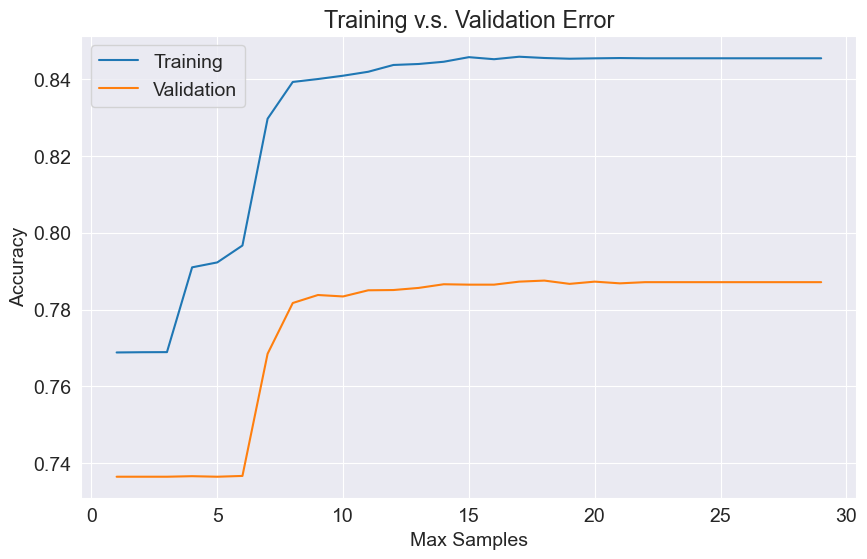

In [151]:
errors_df = pd.DataFrame([test_params(n_estimators=15, max_depth=n, max_leaf_nodes=70, max_features=10,
                                      min_samples_split=16, min_samples_leaf=1,
                                      min_impurity_decrease=0, max_samples=0.5) for n in range(1, 30)])

plt.figure()
plt.plot(list(range(1, 30)), errors_df[0])
plt.plot(list(range(1, 30)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Samples')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

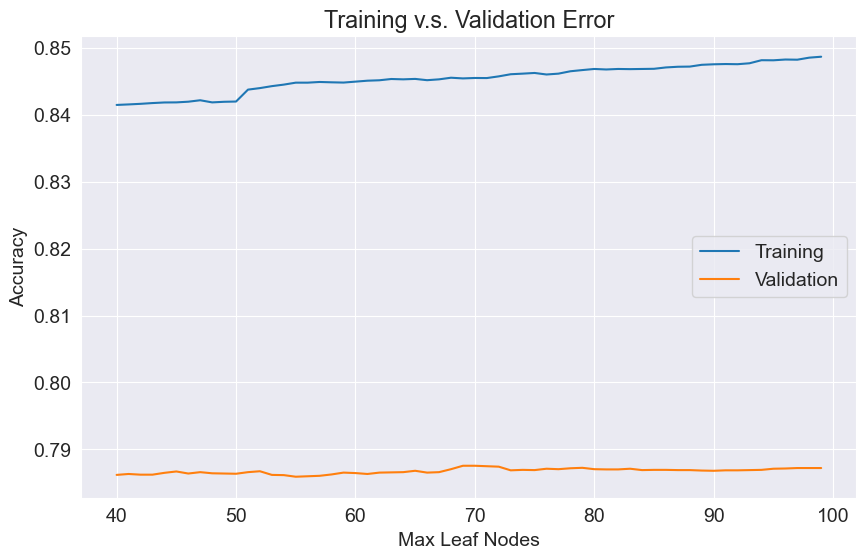

In [154]:
errors_df = pd.DataFrame([test_params(n_estimators=15, max_depth=18, max_leaf_nodes=n, max_features=10,
                                      min_samples_split=16, min_samples_leaf=1,
                                      min_impurity_decrease=0, max_samples=0.5) for n in range(40 ,100)])

plt.figure()
plt.plot(list(range(40, 100)), errors_df[0])
plt.plot(list(range(40, 100)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

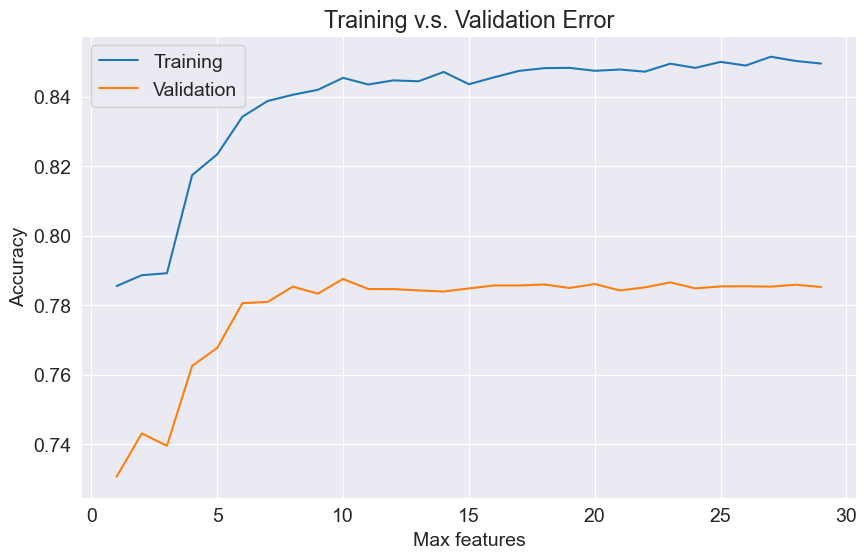

In [156]:
errors_df = pd.DataFrame([test_params(n_estimators=15, max_depth=18, max_leaf_nodes=69, max_features=n,
                                      min_samples_split=16, min_samples_leaf=1,
                                      min_impurity_decrease=0, max_samples=0.5) for n in range(1 ,30)])

plt.figure()
plt.plot(list(range(1, 30)), errors_df[0])
plt.plot(list(range(1, 30)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max features')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

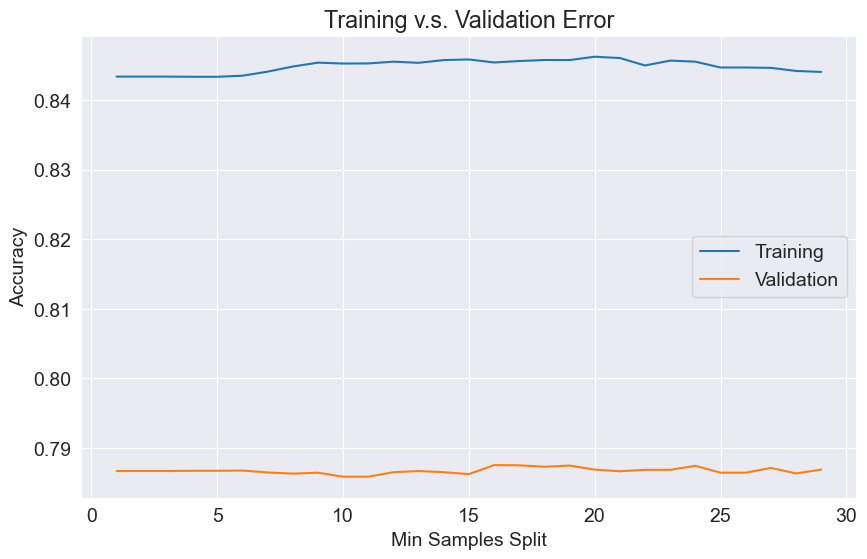

In [158]:
errors_df = pd.DataFrame([test_params(n_estimators=15, max_depth=18, max_leaf_nodes=69, max_features=10,
                                      min_samples_split=n, min_samples_leaf=1,
                                      min_impurity_decrease=0, max_samples=0.5) for n in range(1, 30)])

plt.figure()
plt.plot(list(range(1, 30)), errors_df[0])
plt.plot(list(range(1, 30)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

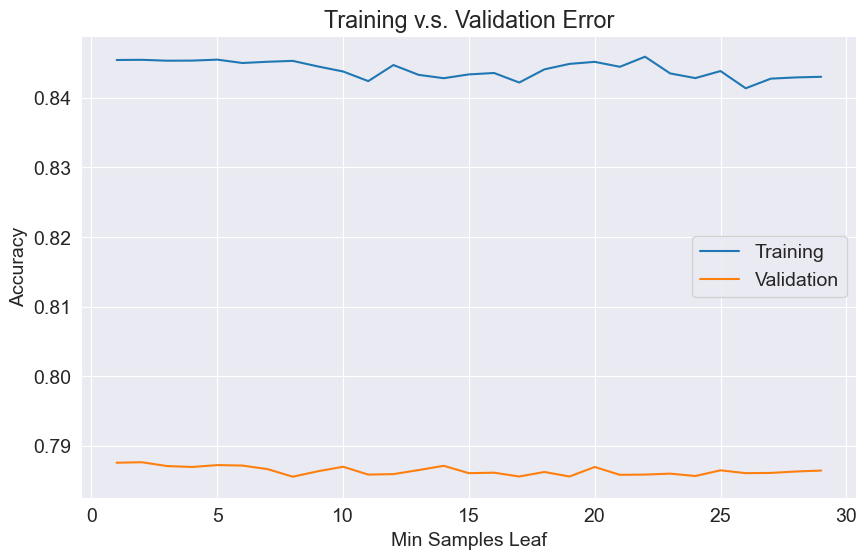

In [160]:
errors_df = pd.DataFrame([test_params(n_estimators=15, max_depth=18, max_leaf_nodes=69, max_features=10,
                                      min_samples_split=16, min_samples_leaf=n,
                                      min_impurity_decrease=0, max_samples=0.5) for n in range(1, 30)])

plt.figure()
plt.plot(list(range(1, 30)), errors_df[0])
plt.plot(list(range(1, 30)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

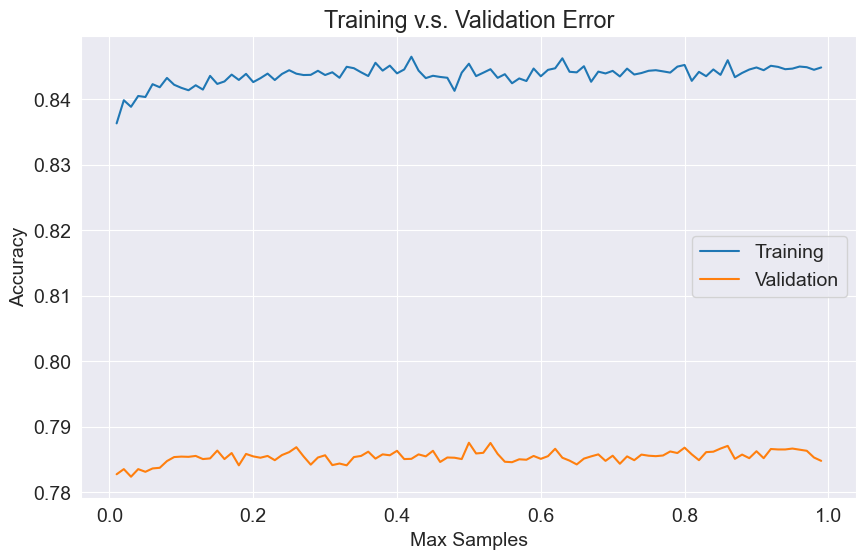

In [163]:
errors_df = pd.DataFrame([test_params(n_estimators=15, max_depth=18, max_leaf_nodes=69, max_features=10,
                                      min_samples_split=16, min_samples_leaf=1,
                                      min_impurity_decrease=0, max_samples=n) for n in np.arange(0.01, 1, 0.01)])

plt.figure()
plt.plot(list(np.arange(0.01, 1, 0.01)), errors_df[0])
plt.plot(list(np.arange(0.01, 1, 0.01)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Samples')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

Repeat Again:

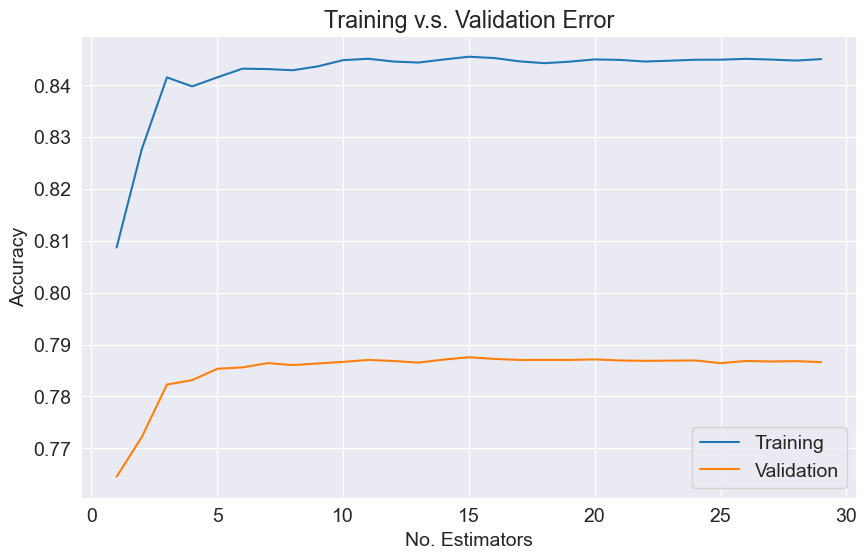

In [173]:
errors_df = pd.DataFrame([test_params(n_estimators=n, max_depth=18, max_leaf_nodes=69, max_features=10,
                                      min_samples_split=16, min_samples_leaf=1,
                                      min_impurity_decrease=0, max_samples=0.5) for n in range(1, 30)])

plt.figure()
plt.plot(list(range(1, 30)), errors_df[0])
plt.plot(list(range(1, 30)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('No. Estimators')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

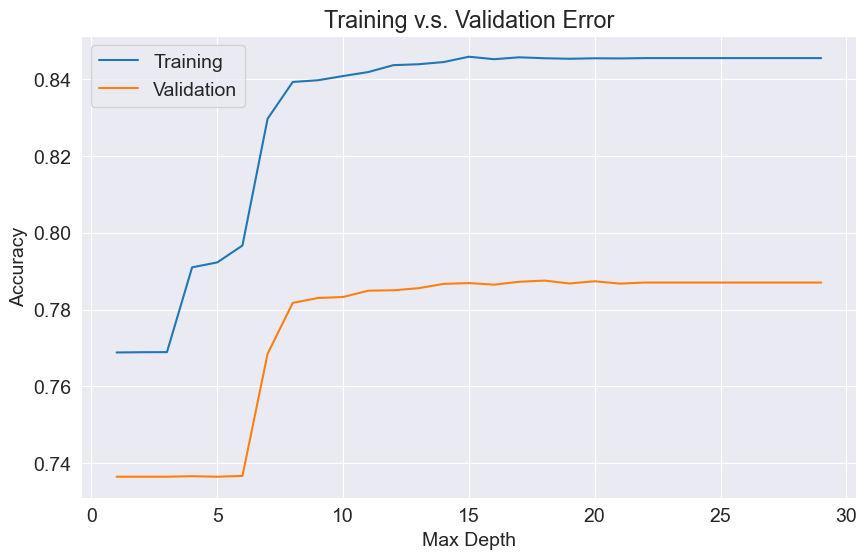

In [174]:
errors_df = pd.DataFrame([test_params(n_estimators=15, max_depth=n, max_leaf_nodes=69, max_features=10,
                                      min_samples_split=16, min_samples_leaf=1,
                                      min_impurity_decrease=0, max_samples=0.5) for n in range(1, 30)])

plt.figure()
plt.plot(list(range(1, 30)), errors_df[0])
plt.plot(list(range(1, 30)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

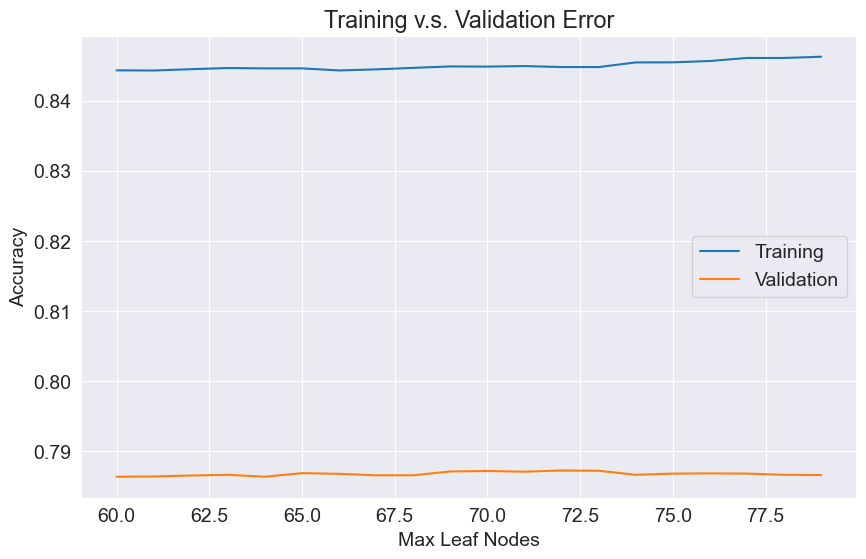

In [176]:
errors_df = pd.DataFrame([test_params(n_estimators=14, max_depth=18, max_leaf_nodes=n, max_features=10,
                                      min_samples_split=16, min_samples_leaf=1,
                                      min_impurity_decrease=0, max_samples=0.5) for n in range(60, 80)])

plt.figure()
plt.plot(list(range(60, 80)), errors_df[0])
plt.plot(list(range(60, 80)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

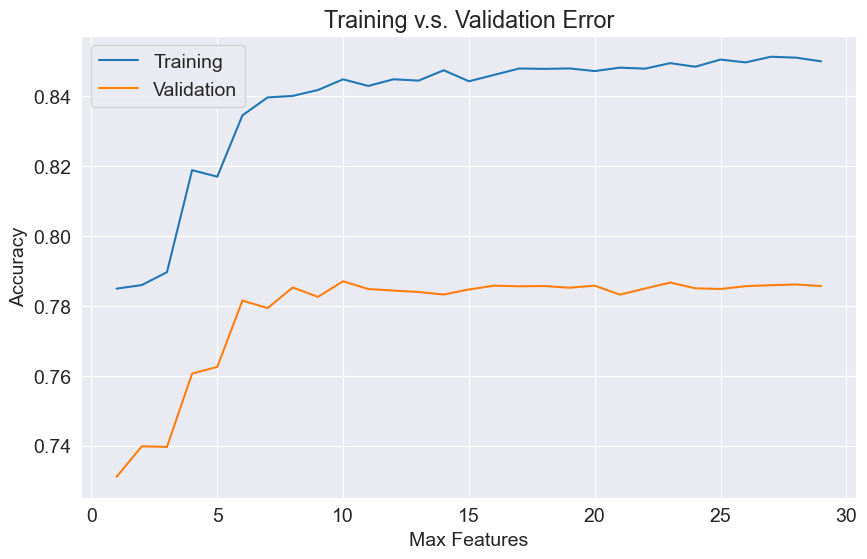

In [177]:
errors_df = pd.DataFrame([test_params(n_estimators=14, max_depth=18, max_leaf_nodes=69, max_features=n,
                                      min_samples_split=16, min_samples_leaf=1,
                                      min_impurity_decrease=0, max_samples=0.5) for n in range(1, 30)])

plt.figure()
plt.plot(list(range(1, 30)), errors_df[0])
plt.plot(list(range(1, 30)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

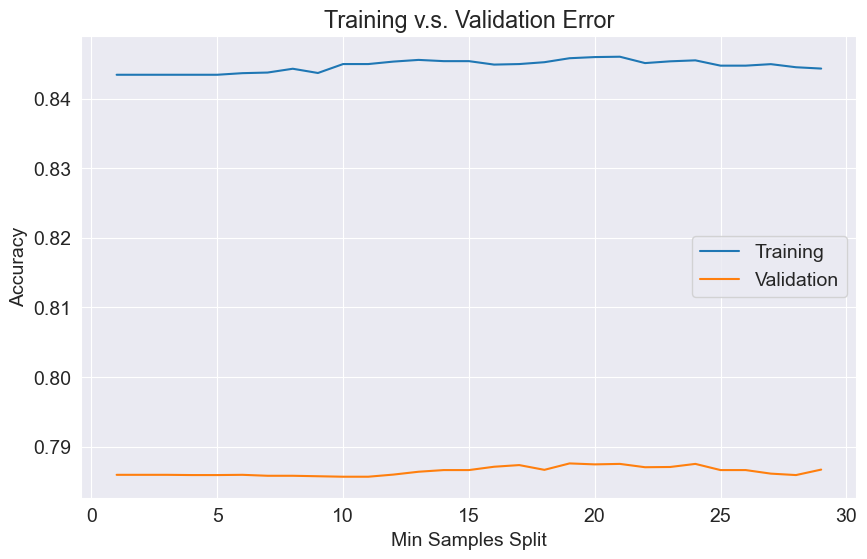

In [179]:
errors_df = pd.DataFrame([test_params(n_estimators=14, max_depth=18, max_leaf_nodes=69, max_features=10,
                                      min_samples_split=n, min_samples_leaf=1,
                                      min_impurity_decrease=0, max_samples=0.5) for n in range(1, 30)])

plt.figure()
plt.plot(list(range(1, 30)), errors_df[0])
plt.plot(list(range(1, 30)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

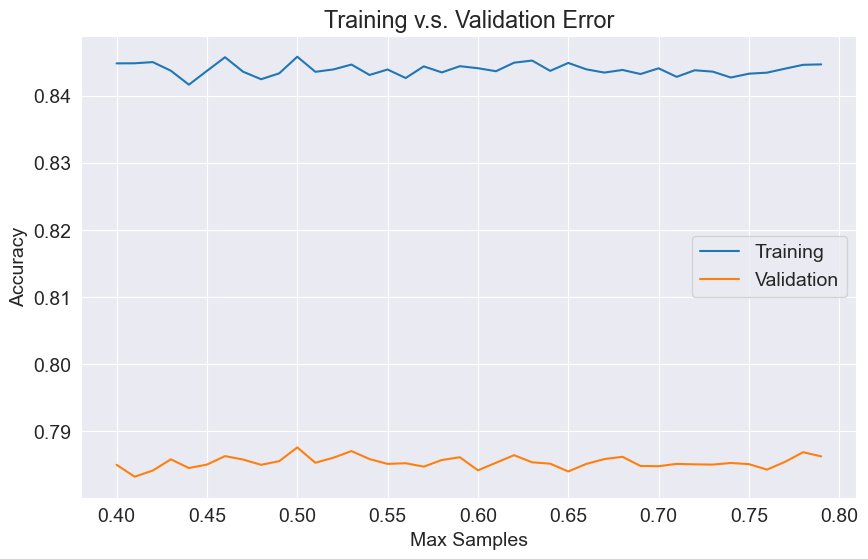

In [183]:
errors_df = pd.DataFrame([test_params(n_estimators=14, max_depth=18, max_leaf_nodes=69, max_features=10,
                                      min_samples_split=19, min_samples_leaf=1,
                                      min_impurity_decrease=0, max_samples=n) for n in np.arange(0.4, 0.8, 0.01)])

plt.figure()
plt.plot(list(np.arange(0.4, 0.8, 0.01)), errors_df[0])
plt.plot(list(np.arange(0.4, 0.8, 0.01)), errors_df[1])
plt.title('Training v.s. Validation Error')
plt.xlabel('Max Samples')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

#### Final Model

In [187]:
rf_model_hptun = RandomForestClassifier(n_estimators=14, max_depth=18, max_leaf_nodes=69, max_features=10,
                                        min_samples_split=19, min_samples_leaf=1,
                                        min_impurity_decrease=0, max_samples=0.5).fit(X_train, train_targets)

### Final Model

In [188]:
rf_model.score(X_val, val_targets)

0.7738643732295826

In [189]:
rf_model_hptun.score(X_val, val_targets)

0.7834886181358998

In [190]:
rf_model_final = rf_model_hptun = RandomForestClassifier(n_estimators=14, max_depth=18, max_leaf_nodes=69, max_features=10,
                                                         min_samples_split=19, min_samples_leaf=1,
                                                         min_impurity_decrease=0, max_samples=0.5).fit(X_train, train_targets)

## Evalue Models
Use Accuracy on validation set to choose best model for this task:

In [260]:
def predict_and_plot(model, inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

Accuracy: 78.71%


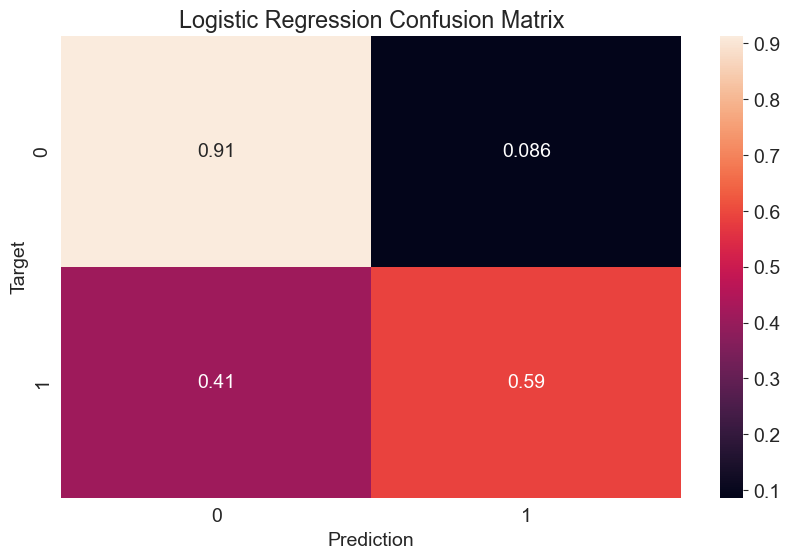

In [276]:
predict_and_plot(logi_model_final, X_val, val_targets, 'Logistic Regression')

Accuracy: 78.12%


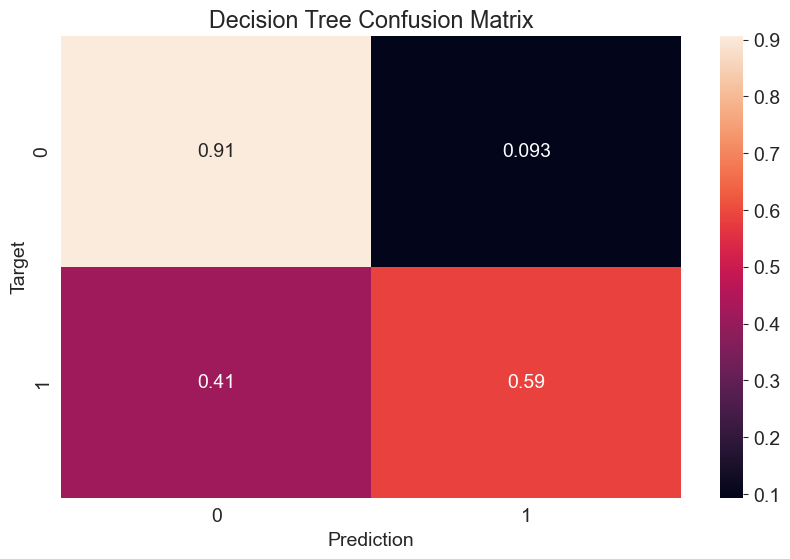

In [277]:
predict_and_plot(dt_model_final, X_val, val_targets, 'Decision Tree')

Accuracy: 78.40%


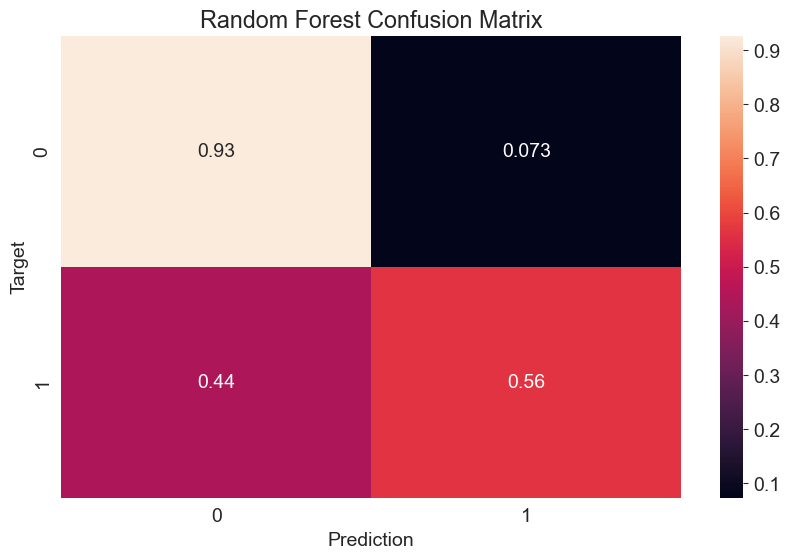

In [278]:
predict_and_plot(rf_model_final, X_val, val_targets, 'Random Forest')

See that logistic regression gives the highest accuracy (although all three models have similar accuracy). And Logistic Regression model gives lowest false negative as well (although it is not main consideration in this task as mentioned before). Hence, choose logistic regression model.

In [279]:
model_final = logi_model_final

## Sample Predictions

In [280]:
sample_input = test_inputs.iloc[0]

In [281]:
sample_input

hotel                            Resort Hotel
lead_time                            0.006784
stays_in_weekend_nights              0.052632
stays_in_week_nights                      0.0
adults                               0.018182
                                     ...     
deposit_type_Refundable                   0.0
customer_type_Contract                    0.0
customer_type_Group                       0.0
customer_type_Transient                   1.0
customer_type_Transient-Party             0.0
Name: 12336, Length: 71, dtype: object

In [282]:
new_input_df = pd.DataFrame([sample_input])

In [283]:
new_input_df[numeric_cols] = imputer.transform(new_input_df[numeric_cols])
new_input_df[numeric_cols] = scaler.transform(new_input_df[numeric_cols])
new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])

X_new_input = new_input_df[numeric_cols + encoded_cols]

In [284]:
prediction = model_final.predict(X_new_input)[0]
prob = model_final.predict_proba(X_new_input)[0]

In [285]:
prediction, prob[0]

(0, 0.8401159706863821)

## On Test Sets

In [286]:
model_final.score(X_test, test_targets)

0.7251010012295802

Accuracy around 72.5%, which is reasonable.
## Save Model

In [287]:
import joblib

In [288]:
hotel_cancellation = {
    'model': model_final,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [289]:
joblib.dump(hotel_cancellation, 'hotel_cancellation.joblib')

['hotel_cancellation.joblib']

## Feature Importance
Since Logistic Regression is chosen, no feature importance is returned. However, hence I’ve scaled the dataset, can use coefficient as a reference of the importance:

In [295]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_final.coef_[0]
}).sort_values('importance', ascending=False)

In [297]:
importance_df.head(10)

,feature,importance
7,previous_cancellations,23.675194
11,adr,6.172219
3,adults,5.058452
57,deposit_type_Non Refund,3.650941
4,children,3.076561
0,lead_time,2.635698
5,babies,2.559372
44,assigned_room_type_A,1.914376
33,distribution_channel_Undefined,1.659152
2,stays_in_week_nights,1.493205


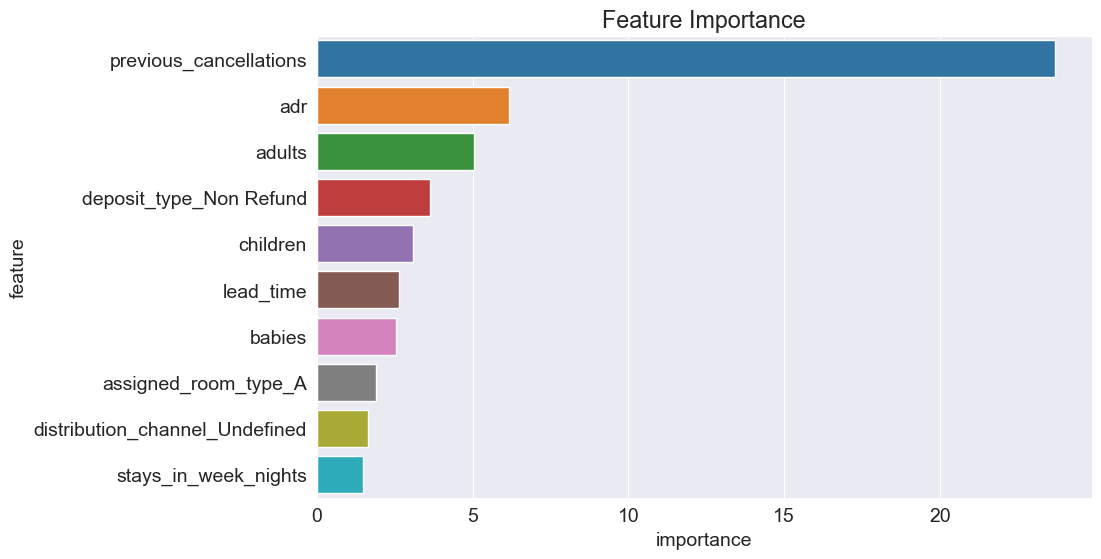

In [298]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

See that Previous cancellations is the most important feature, followed by adr, adults, etc.

## Conclusion
From the propress above, note that logistic regression model works best on the dataset and the aim of the project. However, the accuracy is not very high and the false negative is relative high.
In the future, cross validation can be used to tune the hyperparameters if we can use other package to improve the running time.

## Reference List
1. Kaggle Dataset ([opendataset](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand))
2. All course materials on [Jovian](https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms)
3. [Scikit-learn](https://scikit-learn.org/stable/index.html) documentation
4. [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.isna.html#pandas.isna) documentation